# Concurrent execution

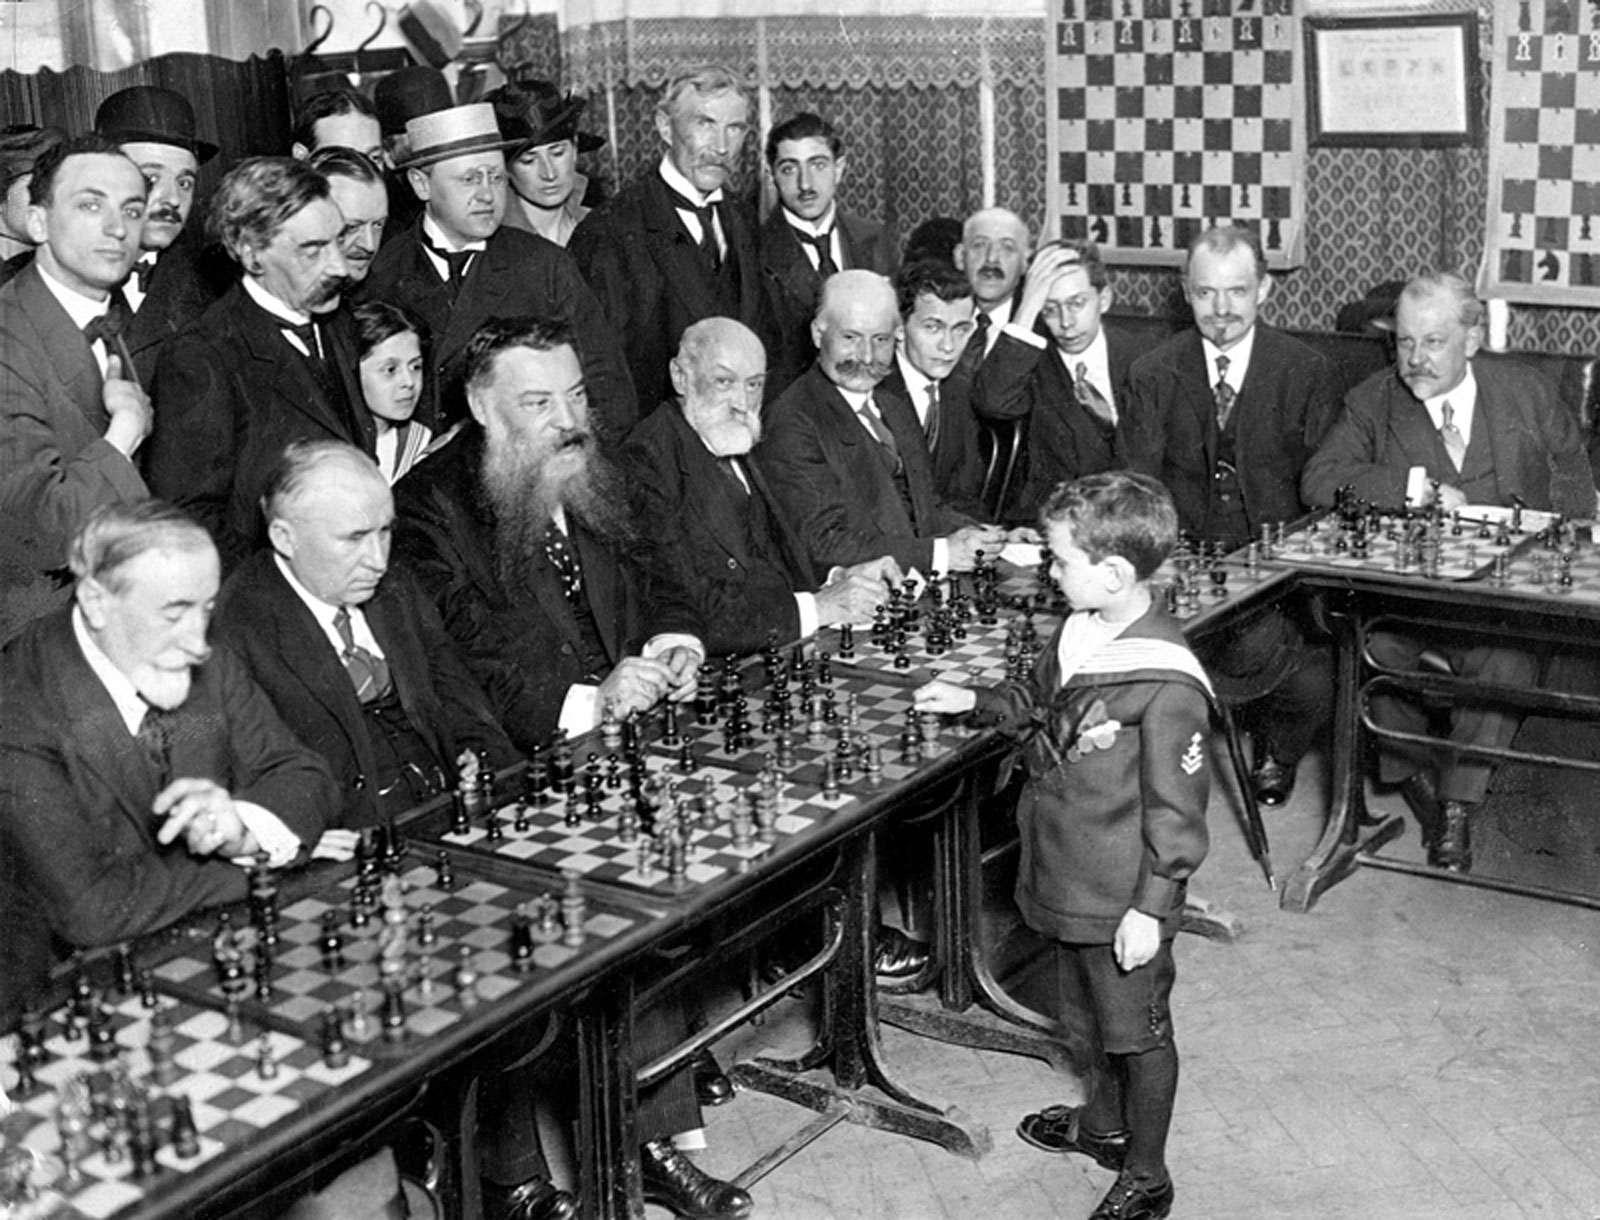

- **Parallelism** consists of performing multiple operations at the same time.
- **Multiprocessing** is a means to effect parallelism.
- **Concurrency** is a slightly broader term than parallelism. It suggests that multiple tasks have the ability to run in an overlapping manner. 
- **Threading** is a concurrent execution model whereby multiple threads take turns executing tasks. One process can contain multiple threads. Python has a complicated relationship with threading thanks to its **GIL**
- The **asyncio** package is billed by the Python documentation as a library to write concurrent code. However, async IO **is not threading**, **nor is it multiprocessing**. It is not built on top of either of these.
- In fact, async IO is **a single-threaded**, **single-process** design: it uses cooperative multitasking

### Running code synchronously

In [22]:
import time
from functools import wraps

def mytimeit(func):
    
    @wraps(func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        res = func(*args, **kwargs)
        t2 = time.time()
        print(f"Elapsed: {(t2 - t1):.2f} seconds")
        
    return wrapper

def count():
    print("One")
    time.sleep(1)
    print("Two")

@mytimeit
def main():
    for _ in range(3):
        count()

if __name__ == "__main__":
    main()

One
Two
One
Two
One
Two
Elapsed: 3.00 seconds


In [23]:
count()

One
Two


### Running code asynchronously

In [24]:
import asyncio

def mytimeit(func):
    
    @wraps(func)
    async def wrapper(*args, **kwargs):
        t1 = time.time()
        res = await func(*args, **kwargs)
        t2 = time.time()
        print(f"Elapsed: {(t2 - t1):.2f} seconds")
        
    return wrapper

async def count():
    print("One")
    await asyncio.sleep(1)
    print("Two")

@mytimeit
async def main():
    await asyncio.gather(count(), count(), count())

if __name__ == "__main__":
    try:
        loop = asyncio.get_running_loop()
    except RuntimeError:  # RuntimeError: There is no current event loop...
        loop = None

    if loop and loop.is_running():
        task = loop.create_task(main())
    else:
        asyncio.run(main())

One
One
One
Two
Two
Two
Elapsed: 1.00 seconds


In [25]:
count()

<coroutine object count at 0x7ff6942f7d40>

### Using regular time.sleep()

In [26]:
import asyncio

def mytimeit(func):
    
    @wraps(func)
    async def wrapper(*args, **kwargs):
        t1 = time.time()
        res = await func(*args, **kwargs)
        t2 = time.time()
        print(f"Elapsed: {(t2 - t1):.2f} seconds")
        
    return wrapper

async def count():
    print("One")
    time.sleep(1)  # The change is here!
    print("Two")

@mytimeit
async def main():
    await asyncio.gather(count(), count(), count())

if __name__ == "__main__":
    try:
        loop = asyncio.get_running_loop()
    except RuntimeError:  # RuntimeError: There is no current event loop...
        loop = None

    if loop and loop.is_running():
        task = loop.create_task(main())
    else:
        asyncio.run(main())

One
Two
One
Two
One
Two
Elapsed: 3.01 seconds


*  *time.sleep()* can represent **any time-consuming blocking function call**, while *asyncio.sleep()* is used to stand in for **a non-blocking call (but one that also takes some time to complete)**.
*  the benefit of awaiting something, including *asyncio.sleep()*, is that **the surrounding function can temporarily cede control to another function that’s more readily able to do something immediately**. In contrast, *time.sleep()* or any other blocking call is incompatible with asynchronous Python code, because it **will stop everything in its tracks for the duration of the sleep time**

## The Rules of Async IO

* The syntax *async def* introduces either a **native coroutine** or an **asynchronous generator**
* The keyword *await* **passes function control back to the event loop.** (It suspends the execution of the surrounding coroutine.) 

In [12]:
async def g():
    # Pause here and come back to g() when f() is ready. In the meantime pick up another coroutine.
    r = await f()
    return r # yield r

In [13]:
async def noop(): pass

### The examples from the Python documentation

In [27]:
async def say_after(delay, what):
    await asyncio.sleep(delay)
    print(what)

@mytimeit    
async def main():
    await say_after(1, 'hello')
    await say_after(2, 'world')

asyncio.create_task(main())

<Task pending name='Task-45' coro=<main() running at /tmp/ipykernel_3855/636290180.py:5>>

hello
world
Elapsed: 3.00 seconds


In [28]:
@mytimeit
async def main():
    task1 = asyncio.create_task(
        say_after(1, 'hello'))
    task2 = asyncio.create_task(
        say_after(2, 'world'))
    # Wait until both tasks are completed (should take
    # around 2 seconds.)
    await task1
    await task2

asyncio.create_task(main())

<Task pending name='Task-46' coro=<main() running at /tmp/ipykernel_3855/636290180.py:5>>

hello
world
Elapsed: 2.00 seconds


Event loops use cooperative scheduling: **an event loop runs one Task at a time**. **While a Task awaits for the completion of a Future, the event loop runs other Tasks, callbacks, or performs IO operations.**

### Awaitables

- An object is **awaitable** if it can be used in an *await* expression.
- There are three main types of awaitable objects: **coroutines, Tasks, and Futures.**

#### Coroutines

In [29]:
import asyncio

async def nested():
    return 42

async def main():
    # Nothing happens if we just call "nested()".
    # A coroutine object is created but not awaited,
    # so it *won't run at all*.
    nested()

    # Let's do it differently now and await it:
    print(await nested())  # will print "42".

asyncio.create_task(main())

<Task pending name='Task-49' coro=<main() running at /tmp/ipykernel_3855/160350200.py:6>>

/tmp/ipykernel_3855/160350200.py:10: RuntimeWarning: coroutine 'nested' was never awaited
  nested()


42


#### Tasks
- Tasks are used to schedule coroutines concurrently.

In [30]:
import asyncio

async def nested():
    return 42

async def main():
    # Schedule nested() to run soon concurrently
    # with "main()".
    task = asyncio.create_task(nested())

    # "task" can now be used to cancel "nested()", or
    # can simply be awaited to wait until it is complete:
    print(await task)

asyncio.create_task(main())

<Task pending name='Task-50' coro=<main() running at /tmp/ipykernel_3855/2817646389.py:6>>

42


#### Futures
- A Future is a special low-level awaitable object that represents an eventual result of an asynchronous operation.
- Normally there is no need to create Future objects at the application level code.
- Future objects, sometimes exposed by libraries and some asyncio APIs, can be awaited:

In [31]:
async def set_after(fut, delay, value):
    # Sleep for *delay* seconds.
    await asyncio.sleep(delay)

    # Set *value* as a result of *fut* Future.
    fut.set_result(value)

async def main():
    # Get the current event loop.
    loop = asyncio.get_running_loop()

    # Create a new Future object.
    fut = loop.create_future()

    # Run "set_after()" coroutine in a parallel Task.
    # We are using the low-level "loop.create_task()" API here because
    # we already have a reference to the event loop at hand.
    # Otherwise we could have just used "asyncio.create_task()".
    loop.create_task(
        set_after(fut, 1, '... world'))

    print('hello ...')

    # Wait until *fut* has a result (1 second) and print it.
    print(await fut)

asyncio.create_task(main())

<Task pending name='Task-52' coro=<main() running at /tmp/ipykernel_3855/1093269536.py:8>>

hello ...
... world


#### Running Tasks Concurrently ( asyncio.gather() )
- Run awaitable objects in the awaitables sequence concurrently.
- If any awaitable in awaitables is a coroutine, it is automatically scheduled as a Task.
- If all awaitables are completed successfully, the result is an aggregate list of returned values. The order of result values corresponds to the order of awaitables in aws.

In [32]:
import asyncio

async def factorial(name, number):
    f = 1
    for i in range(2, number + 1):
        print(f"Task {name}: Compute factorial({number}), currently i={i}...")
        await asyncio.sleep(1)
        f *= i
    print(f"Task {name}: factorial({number}) = {f}")
    return f

async def main():
    # Schedule three calls *concurrently*:
    L = await asyncio.gather(
        factorial("A", 2),
        factorial("B", 3),
        factorial("C", 4),
    )
    print(L)

asyncio.create_task(main())

# Expected output:
#
#     Task A: Compute factorial(2), currently i=2...
#     Task B: Compute factorial(3), currently i=2...
#     Task C: Compute factorial(4), currently i=2...
#     Task A: factorial(2) = 2
#     Task B: Compute factorial(3), currently i=3...
#     Task C: Compute factorial(4), currently i=3...
#     Task B: factorial(3) = 6
#     Task C: Compute factorial(4), currently i=4...
#     Task C: factorial(4) = 24
#     [2, 6, 24]

<Task pending name='Task-54' coro=<main() running at /tmp/ipykernel_3855/107675220.py:12>>

Task A: Compute factorial(2), currently i=2...
Task B: Compute factorial(3), currently i=2...
Task C: Compute factorial(4), currently i=2...
Task A: factorial(2) = 2
Task B: Compute factorial(3), currently i=3...
Task C: Compute factorial(4), currently i=3...
Task B: factorial(3) = 6
Task C: Compute factorial(4), currently i=4...
Task C: factorial(4) = 24
[2, 6, 24]


#### Shielding From Cancellation

In [33]:
from asyncio import shield

res = await shield(something())

NameError: name 'something' is not defined

#### Timeouts

In [34]:
async def eternity():
    # Sleep for one hour
    await asyncio.sleep(3600)
    print('yay!')

async def main():
    # Wait for at most 1 second
    try:
        await asyncio.wait_for(eternity(), timeout=1.0)
    except asyncio.TimeoutError:
        print('timeout!')

asyncio.create_task(main())

<Task pending name='Task-59' coro=<main() running at /tmp/ipykernel_3855/1445981297.py:6>>

timeout!


- https://docs.python.org/3/library/asyncio-task.html#coroutines
- https://realpython.com/async-io-python/

## Queues

- Queues can be used to distribute workload between several concurrent tasks:

In [35]:
import asyncio
import random
import time


async def worker(name, queue):
    while True:
        # Get a "work item" out of the queue.
        sleep_for = await queue.get()

        # Sleep for the "sleep_for" seconds.
        await asyncio.sleep(sleep_for)

        # Notify the queue that the "work item" has been processed.
        queue.task_done()

        print(f'{name} has slept for {sleep_for:.2f} seconds')


async def main():
    # Create a queue that we will use to store our "workload".
    queue = asyncio.Queue()

    # Generate random timings and put them into the queue.
    total_sleep_time = 0
    for _ in range(20):
        sleep_for = random.uniform(0.05, 1.0)
        total_sleep_time += sleep_for
        queue.put_nowait(sleep_for)

    # Create three worker tasks to process the queue concurrently.
    tasks = []
    for i in range(3):
        task = asyncio.create_task(worker(f'worker-{i}', queue))
        tasks.append(task)

    # Wait until the queue is fully processed.
    started_at = time.monotonic()
    await queue.join()
    total_slept_for = time.monotonic() - started_at

    # Cancel our worker tasks.
    for task in tasks:
        task.cancel()
    # Wait until all worker tasks are cancelled.
    await asyncio.gather(*tasks, return_exceptions=True)

    print('====')
    print(f'3 workers slept in parallel for {total_slept_for:.2f} seconds')
    print(f'total expected sleep time: {total_sleep_time:.2f} seconds')


asyncio.create_task(main())


<Task pending name='Task-61' coro=<main() running at /tmp/ipykernel_3855/3535941052.py:20>>

worker-0 has slept for 0.14 seconds
worker-1 has slept for 0.28 seconds
worker-2 has slept for 0.47 seconds
worker-0 has slept for 0.65 seconds
worker-1 has slept for 0.71 seconds
worker-2 has slept for 0.55 seconds
worker-0 has slept for 0.73 seconds
worker-2 has slept for 0.52 seconds
worker-1 has slept for 0.59 seconds
worker-2 has slept for 0.59 seconds
worker-1 has slept for 0.59 seconds
worker-2 has slept for 0.12 seconds
worker-0 has slept for 0.92 seconds
worker-2 has slept for 0.42 seconds
worker-2 has slept for 0.35 seconds
worker-1 has slept for 0.88 seconds
worker-0 has slept for 0.83 seconds
worker-2 has slept for 0.25 seconds
worker-0 has slept for 0.42 seconds
worker-1 has slept for 0.92 seconds
====
3 workers slept in parallel for 3.98 seconds
total expected sleep time: 10.94 seconds
